# CEIA - Procesamiento de Lenguaje Natural

## Estudiante: a2124 - Ricardo Silvera

--- 

# Desafío 3

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


---


In [1]:
import tensorflow as tf
import os

print("="*70)
print("CONFIGURACIÓN DE GPU OPTIMIZADA")
print("="*70)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"¿Construido con CUDA?: {tf.test.is_built_with_cuda()}")

# Listar dispositivos físicos
print("\n--- Dispositivos disponibles ---")
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(f"CPUs: {len(cpus)}")
print(f"GPUs: {len(gpus)}")

if gpus:
    print(f"\n✓ GPU detectada: {gpus[0].name}")
    
    try:
        # Configurar crecimiento de memoria (CRÍTICO para GTX 1050)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Limitar memoria a 3GB
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
        
        print("✓ Crecimiento de memoria GPU: ACTIVADO")
        print("✓ Límite de memoria GPU: 3GB")
        
        # Configurar para forzar operaciones en GPU
        tf.config.set_soft_device_placement(False)
        
        # Test simple en GPU
        with tf.device('/GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)
        
        print(f"✓ Test de operación en GPU: EXITOSO")
        print(f"  Dispositivo: {c.device}")
        print("✓ Soft device placement: DESACTIVADO (forzar GPU)")
        
    except RuntimeError as e:
        print(f"\n⚠ Error configurando GPU: {e}")
else:
    print("\n⚠ No se detectaron GPUs")

print("\n" + "="*70)

2025-12-14 19:08:48.231417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-14 19:08:48.254830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-14 19:08:48.254886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-14 19:08:48.270047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 19:08:49.274360: W tensorflow/compiler/tf

CONFIGURACIÓN DE GPU OPTIMIZADA

TensorFlow version: 2.16.2
¿Construido con CUDA?: True

--- Dispositivos disponibles ---
CPUs: 1
GPUs: 1

✓ GPU detectada: /physical_device:GPU:0
✓ Crecimiento de memoria GPU: ACTIVADO
✓ Límite de memoria GPU: 3GB
✓ Test de operación en GPU: EXITOSO
  Dispositivo: /job:localhost/replica:0/task:0/device:GPU:0
✓ Soft device placement: DESACTIVADO (forzar GPU)



2025-12-14 19:08:51.095687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-14 19:08:51.138638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-14 19:08:51.138906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Imporación de librerias 

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop

## Selección del corpus

Seleccioné como corpus el texto de la novela "Alicia en el País de las Maravillas" de Lewis Carroll. El texto se encuentra en español y es una obra clásica con un vocabulario rico y variado. 
Inicialmente selección "Crímen y Castigo", pero al ser mucho más mgrande conmece con problemas en la utilización de la memoria y decidí reducir el taamaño de la entrda con un libro más pequeño.

In [3]:
# Lectura del corpus
with open('alicia-en-el-pais-de-las-maravillas.txt', 'r', encoding='utf-8') as f:
    article_text = f.read()

# Pasar todo el texto a minúscula
article_text = article_text.lower()

# Verificar la longitud del corpus
print(f"Longitud del corpus: {len(article_text)} caracteres")
print(f"Primeros 500 caracteres:\n{article_text[:500]}")

Longitud del corpus: 153928 caracteres
Primeros 500 caracteres:
en la madriguera
alicia empezaba a sentirse cansadísima de estar sentada en un margen, al lado de su hermana, sin saber qué hacer: por dos veces había atisbado el libro que ella leía, pero era un libro sin grabados, sin diálogo, y «¿de qué sirve un libro —se dijo alicia— si no tiene diálogo ni grabados?».

y de la mejor manera que le permitían la somnolencia y el atontamiento en que la había sumido el calor de aquella jornada, consideraba en su fuero interno si valdría la pena entretenerse en ar


## Pre-procesamiento

### Construcción del vocabulario

El vocabulario es el conjunto único de caracteres que existe en todo el texto

In [4]:
# Ordeno alfabéticamente para tener un mapeo consistente
chars_vocab = sorted(set(article_text))

# La longitud del vocabulario de caracteres es:
vocab_size = len(chars_vocab)
print(f"Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"Caracteres: {chars_vocab}")

Tamaño del vocabulario: 64 caracteres únicos
Caracteres: ['\n', ' ', '!', '"', '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ù', 'ú', 'ü', '—', '“', '”']


Creo los diccionarios que asignan índices a caracteres y viceversa

In [5]:

# El diccionario char2idx servirá como tokenizador

char2idx = {char: idx for idx, char in enumerate(chars_vocab)}
idx2char = {idx: char for idx, char in enumerate(chars_vocab)}

# Guardo los diccionarios para uso futuro y no tener qeu volvel a entrenar los modelos
import pickle
with open('char2idx.pkl', 'wb') as f:
    pickle.dump(char2idx, f)
with open('idx2char.pkl', 'wb') as f:
    pickle.dump(idx2char, f)
print("Diccionarios guardados: char2idx.pkl, idx2char.pkl")

Diccionarios guardados: char2idx.pkl, idx2char.pkl


Visualización de los diccionarios

In [6]:
print("Char to Index:")
print(char2idx)
print("Index to Char:")
print(idx2char)

Char to Index:
{'\n': 0, ' ': 1, '!': 2, '"': 3, '(': 4, ')': 5, '*': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'a': 23, 'b': 24, 'c': 25, 'd': 26, 'e': 27, 'f': 28, 'g': 29, 'h': 30, 'i': 31, 'j': 32, 'k': 33, 'l': 34, 'm': 35, 'n': 36, 'o': 37, 'p': 38, 'q': 39, 'r': 40, 's': 41, 't': 42, 'u': 43, 'v': 44, 'w': 45, 'x': 46, 'y': 47, 'z': 48, '¡': 49, '«': 50, '»': 51, '¿': 52, 'á': 53, 'é': 54, 'í': 55, 'ñ': 56, 'ó': 57, 'ù': 58, 'ú': 59, 'ü': 60, '—': 61, '“': 62, '”': 63}
Index to Char:
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '(', 5: ')', 6: '*', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '?', 23: 'a', 24: 'b', 25: 'c', 26: 'd', 27: 'e', 28: 'f', 29: 'g', 30: 'h', 31: 'i', 32: 'j', 33: 'k', 34: 'l', 35: 'm', 36: 'n', 37: 'o', 38: 'p', 39: 'q', 40: 'r', 41: 's', 42: 't', 43: 'u', 44: 'v', 45: '

### Tokenización

In [7]:
tokenized_text = [char2idx[ch] for ch in article_text]
print(f"Longitud del texto tokenizado: {len(tokenized_text)}")
print(f"Primeros 100 tokens: {tokenized_text[:100]}")

Longitud del texto tokenizado: 153928
Primeros 100 tokens: [27, 36, 1, 34, 23, 1, 35, 23, 26, 40, 31, 29, 43, 27, 40, 23, 0, 23, 34, 31, 25, 31, 23, 1, 27, 35, 38, 27, 48, 23, 24, 23, 1, 23, 1, 41, 27, 36, 42, 31, 40, 41, 27, 1, 25, 23, 36, 41, 23, 26, 55, 41, 31, 35, 23, 1, 26, 27, 1, 27, 41, 42, 23, 40, 1, 41, 27, 36, 42, 23, 26, 23, 1, 27, 36, 1, 43, 36, 1, 35, 23, 40, 29, 27, 36, 7, 1, 23, 34, 1, 34, 23, 26, 37, 1, 26, 27, 1, 41, 43]


### Selección del tamaño de contexto

Como la tokenización es por caracter, la cantodad de tokens es igual a la cantidad de caracteres en el texto: 1044667. Todo el corpus puede ser considerado un documento  y el tamaño de contexto puede ser elegido con mayor libertad en comparación a un modelo tokenizado por palabras.

In [8]:
# Seleccionamos el tamaño de contexto
max_context_size = 100

### Estructuración del dataset

Separo el dataset en entrenamiento y validación. Utilizo una 10% para validación.

In [9]:
#p_val es la proporcion del corpus que uso para validación 
p_val = 0.1

# num_val es la cantidad de secuencias de tamaño max_context_size que se usará en validación
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))

print(f"Número de secuencias para validación: {num_val}")

Número de secuencias para validación: 154


In [10]:
# Datos de entrenamiento
train_text = tokenized_text[:-num_val * max_context_size]
# Datos de validación
val_text = tokenized_text[-num_val * max_context_size:]

print(f"Longitud del texto de entrenamiento: {len(train_text)}")
print(f"Longitud del texto de validación: {len(val_text)}")

Longitud del texto de entrenamiento: 138528
Longitud del texto de validación: 15400


Creación de las secuencias

In [11]:
# Secuencias de validación
tokenized_sentences_val = [val_text[init * max_context_size:init * (max_context_size + 1)] 
                           for init in range(num_val)]

# Secuencias de entrenamiento
tokenized_sentences_train = [train_text[init:init + max_context_size] 
                             for init in range(len(train_text) - max_context_size + 1)]

print(f"Número de secuencias de entrenamiento: {len(tokenized_sentences_train)}")
print(f"Número de secuencias de validación: {len(tokenized_sentences_val)}")

Número de secuencias de entrenamiento: 138429
Número de secuencias de validación: 154


In [12]:
# Estructuramos el problema como many-to-many:
# Entrada: secuencia de tokens [x_0, x_1, ..., x_N]
# Target: secuencia de tokens [x_1, x_2, ..., x_{N+1}]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nEjemplo - Primeros 10 tokens de X[0]: {X[0, :10]}")
print(f"Ejemplo - Primeros 10 tokens de y[0]: {y[0, :10]}")

Shape de X: (138428, 100)
Shape de y: (138428, 100)

Ejemplo - Primeros 10 tokens de X[0]: [27 36  1 34 23  1 35 23 26 40]
Ejemplo - Primeros 10 tokens de y[0]: [36  1 34 23  1 35 23 26 40 31]


## Arquitecturas

### Callback de Perplejidad

Implemento el callback ad-hoc para calcular la perplejidad al final de cada epoch de entrenamiento sobre un conjunto de datos de validación. La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias. Además implementa Early Stopping si la perplejidad no mejora después de `patience` epochs.

In [13]:
class PplCallback(keras.callbacks.Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5, batch_size=64):
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad
        self.val_data = val_data
        self.batch_size = batch_size  # Batch size para predicciones (menor para evitar OOM)
        self.history_ppl=history_ppl
        self.target = []
        self.padded = []

        count = 0
        self.info = []
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:
            len_seq = len(seq)
            # armamos todas las subsecuencias
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])

            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq

        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # Predicciones en batches pequeños para evitar OOM
        predictions = []
        num_samples = len(self.padded)
        
        for i in range(0, num_samples, self.batch_size):
            batch = self.padded[i:i + self.batch_size]
            batch_pred = self.model.predict(batch, verbose=0)
            predictions.append(batch_pred)
        
        # Concatenar todas las predicciones
        predictions = np.vstack(predictions)

        # para cada secuencia de validación
        for start, end in self.info:
            # en `probs` iremos guardando las probabilidades de los términos target
            probs = [predictions[idx_seq, -1, idx_vocab] 
                    for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]
            
            # Convertir a array de NumPy antes de operaciones matemáticas
            probs = np.array(probs)

            # calculamos la perplejidad por medio de logaritmos
            scores.append(np.exp(-np.sum(np.log(probs + 1E-10)) / (end - start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\nmean perplexity: {current_score}\n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("best_model.keras")
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True

In [14]:
# Función auxiliar para crear diferentes arquitecturas de modelos
def crear_modelo(tipo_rnn='SimpleRNN', hidden_units=200, dropout=0.1, recurrent_dropout=0.1, num_layers=1, learning_rate=0.001):
    """
    Crea un modelo de lenguaje con la arquitectura especificada.
    
    Args:
        tipo_rnn: tipo de capa recurrente ('SimpleRNN', 'LSTM', 'GRU')
        hidden_units: número de unidades ocultas en la capa recurrente
        dropout: tasa de dropout
        recurrent_dropout: tasa de dropout recurrente
        num_layers: número de capas recurrentes apiladas (1, 2 o 3)
    
    Returns:
        modelo compilado
    """
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        
        model = Sequential()
        
        # Capa de codificación one-hot
        model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
                                input_shape=(None, 1)))
        
        # Capas recurrentes apiladas
        for layer_idx in range(num_layers):
            # Todas las capas deben tener return_sequences=True
            if tipo_rnn == 'SimpleRNN':
                model.add(SimpleRNN(hidden_units, return_sequences=True, 
                                dropout=dropout, recurrent_dropout=recurrent_dropout))
            elif tipo_rnn == 'LSTM':
                model.add(LSTM(hidden_units, return_sequences=True, 
                            dropout=dropout, recurrent_dropout=recurrent_dropout))
            elif tipo_rnn == 'GRU':
                model.add(GRU(hidden_units, return_sequences=True, 
                            dropout=dropout, recurrent_dropout=recurrent_dropout))
            else:
                raise ValueError(f"Tipo de RNN no soportado: {tipo_rnn}")
        
        # Capa de salida
        model.add(Dense(vocab_size, activation='softmax'))
        
        # Compilación del modelo con métricas adicionales
        model.compile(loss='sparse_categorical_crossentropy', 
                     optimizer=RMSprop(learning_rate)
                     )
    
    return model

#### Modelo 1: SimpleRNN

In [ ]:
# Configuración para SimpleRNN 
model_simplernn_v2 = crear_modelo(
    tipo_rnn='SimpleRNN', 
    hidden_units=512,           
    dropout=0.05,               
    recurrent_dropout=0.05,     
    num_layers=3,               
    learning_rate=0.0005        
)
print("Modelo SimpleRNN creado")

/home/gury/python/pln/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo SimpleRNN mejorado creado (pero se recomienda usar LSTM)


In [ ]:
# Crear modelo SimpleRNN 
model_simplernn = crear_modelo(
    tipo_rnn='SimpleRNN', 
    hidden_units=256,           
    dropout=0.2,                
    recurrent_dropout=0.1,      
    num_layers=2,               
    learning_rate=0.001        
)
model_simplernn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 256)      │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, None, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 64)       │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,952 (898.25 KB)

 Trainable params: 229,952 (898.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Entrenamiento del modelo SimpleRNN
# Usar batch_size más pequeño para evitar problemas de memoria
history_ppl_simplernn = []
hist_simplernn = model_simplernn.fit(X, y, epochs=20, 
                                      callbacks=[PplCallback(tokenized_sentences_val, history_ppl_simplernn, patience=5, batch_size=32)], 
                                      batch_size=64, verbose=1)

Epoch 1/20


I0000 00:00:1765723087.422313    7118 service.cc:145] XLA service 0x328a3fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765723087.422338    7118 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-12-14 11:38:07.818829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1765723087.890569    7118 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-14 11:38:07.818829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1765723087.890569    7118 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossE

   5/2163 ━━━━━━━━━━━━━━━━━━━━ 1:15 35ms/step - loss: 4.1407

I0000 00:00:1765723095.008249    7118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2161/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.2512

W0000 00:00:1765723171.847720    7115 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.2510
mean perplexity: 5.647215525109737

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 128s 53ms/step - loss: 2.0205
Epoch 2/20

mean perplexity: 5.647215525109737

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 128s 53ms/step - loss: 2.0205
Epoch 2/20
2162/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8006
mean perplexity: 5.468835991565899

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 104s 48ms/step - loss: 1.7800
Epoch 3/20

mean perplexity: 5.468835991565899

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 104s 48ms/step - loss: 1.7800
Epoch 3/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.7382
mean perplexity: 5.392879334892373

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 101s 47ms/step - loss: 1.7313
Epoch 4/20

mean perplexity: 5.392879334892373

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 101s 47ms/step - loss: 1.7313
Epoch 4/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.7146
mean perple

Comencé con una arquitectura simple de **1 capa** y **64 unidades ocultas**, pero los resultados fueron pobres, con un **loss** cercano a 2. Fui ajustando hiperparámetros: **learning rate, batch size y número de capas** hasta llegar a configuraciones más equilibradas, obteniendo resultados acordes a los recursos disponibles y el tiempo de entrenamiento disponible. En varios intentos el **error** bajaba por época, pero la **perplejidad** aumentaba, señal de sobreajuste.

#### Modelo 2: LSTM

In [37]:
model_lstm = crear_modelo(
    tipo_rnn='LSTM', 
    hidden_units=192,           
    num_layers=3,               
    dropout=0.1,                
    recurrent_dropout=0,      
    learning_rate=0.0005
)
model_lstm.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, None, 192)      │       197,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, None, 192)      │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, None, 192)      │       295,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, None, 64)       │        12,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,088 (3.06 MB)

 Trainable params: 801,088 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Entrenar
history_ppl_lstm = []
hist_lstm = model_lstm.fit(
    X, y, 
    epochs=40, 
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl_lstm, patience=5, batch_size=32)], 
    batch_size=32, 
    verbose=1
)

Epoch 1/40
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.9339
mean perplexity: 8.510522694363019

Saved new model!
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 222s 50ms/step - loss: 2.6546
Epoch 2/40
4325/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.0964
mean perplexity: 6.846721194331346

Saved new model!
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 179s 41ms/step - loss: 2.0284
Epoch 3/40
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8643
mean perplexity: 6.222145190909451

Saved new model!
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 254s 59ms/step - loss: 1.8237
Epoch 4/40
4325/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.7173
mean perplexity: 5.7541759122472795

Saved new model!
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 179s 41ms/step - loss: 1.6876
Epoch 5/40
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6079
mean perplexity: 5.547005513670106

Saved new model!
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 235s 54ms/step - loss: 1.5844
Epoch 6/40
4326/4326 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.5206
mean perp

Al igual que con el modelo RNN simple, exploré múltiples combinaciones de hiperparámetros para reducir la perplejidad. Las pruebas con 3 capas resultó excesivo para un corpus relativamente pequeño: el error no bajaba y la perplejidad aumentaba. Volví a arquitecturas más compactas (1 capa), donde el loss descendía bien pero surgía overfitting. Para mitigarlo, incorporé dropout y recurrent_dropout, reduje el learning rate y extendí el número de épocas, logrando una curva de entrenamiento más estable y una mejor generalización

#### Modelo 3: GRU

In [22]:
# Crear modelo GRU
model_gru = crear_modelo(tipo_rnn='GRU', 
                         hidden_units=256, 
                         num_layers=1, 
                         dropout=0.2, 
                         recurrent_dropout=0.1,
                         learning_rate=0.0005)
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, None, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 256)      │       247,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 64)       │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,744 (1.01 MB)

 Trainable params: 263,744 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamiento del modelo GRU
history_ppl_gru = []

hist_gru = model_gru.fit(
        X, y, 
        epochs=20, 
        callbacks=[PplCallback(tokenized_sentences_val, history_ppl_gru, patience=5, batch_size=32)], 
        batch_size=40,
        verbose=1
)

Epoch 1/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 2.5554
mean perplexity: 7.19170915802504

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 327s 148ms/step - loss: 2.2777
Epoch 2/20

mean perplexity: 7.19170915802504

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 327s 148ms/step - loss: 2.2777
Epoch 2/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.9443
mean perplexity: 6.137923223004613

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 350s 162ms/step - loss: 1.8836
Epoch 3/20

mean perplexity: 6.137923223004613

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 350s 162ms/step - loss: 1.8836
Epoch 3/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.7272
mean perplexity: 5.765755514612939

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 369s 170ms/step - loss: 1.6881
Epoch 4/20

mean perplexity: 5.765755514612939

Saved new model!
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 369s 170ms/step - loss: 1.6881
Epoch 4/20
2163/2163 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss:

### Comparación de modelos

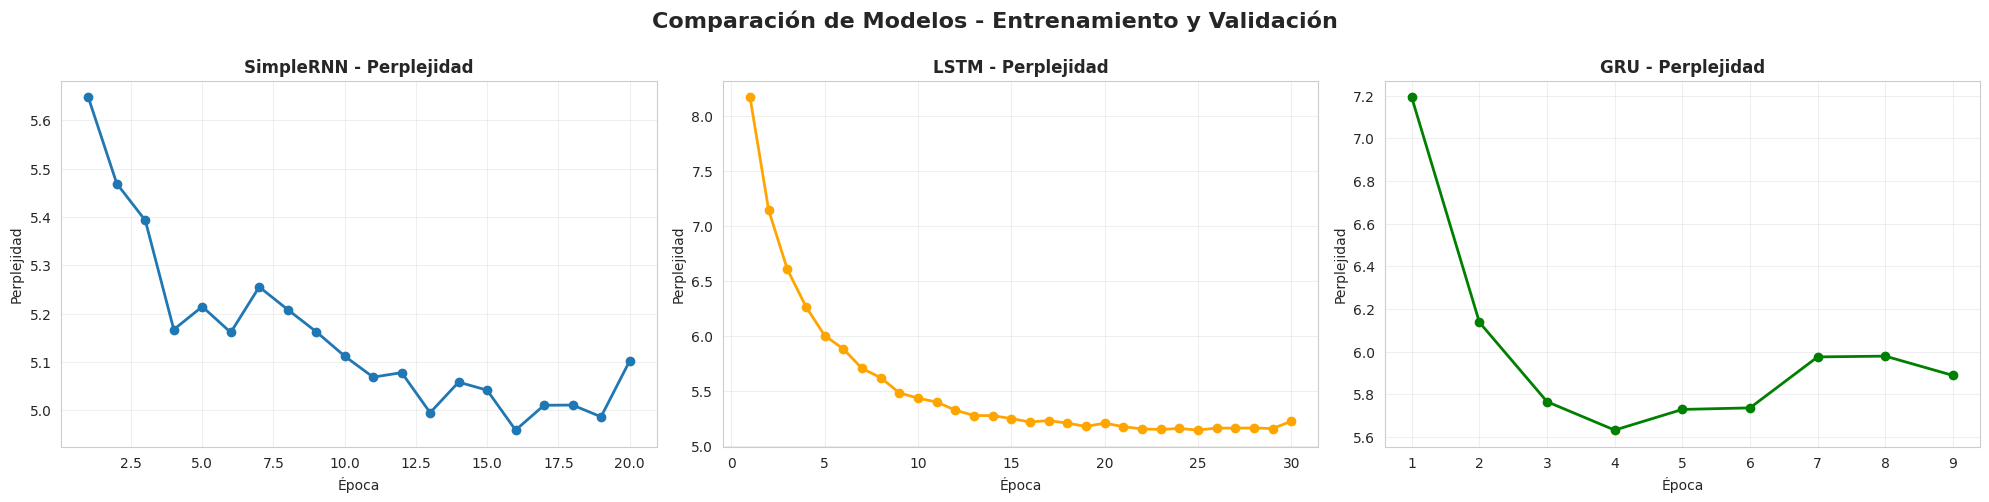

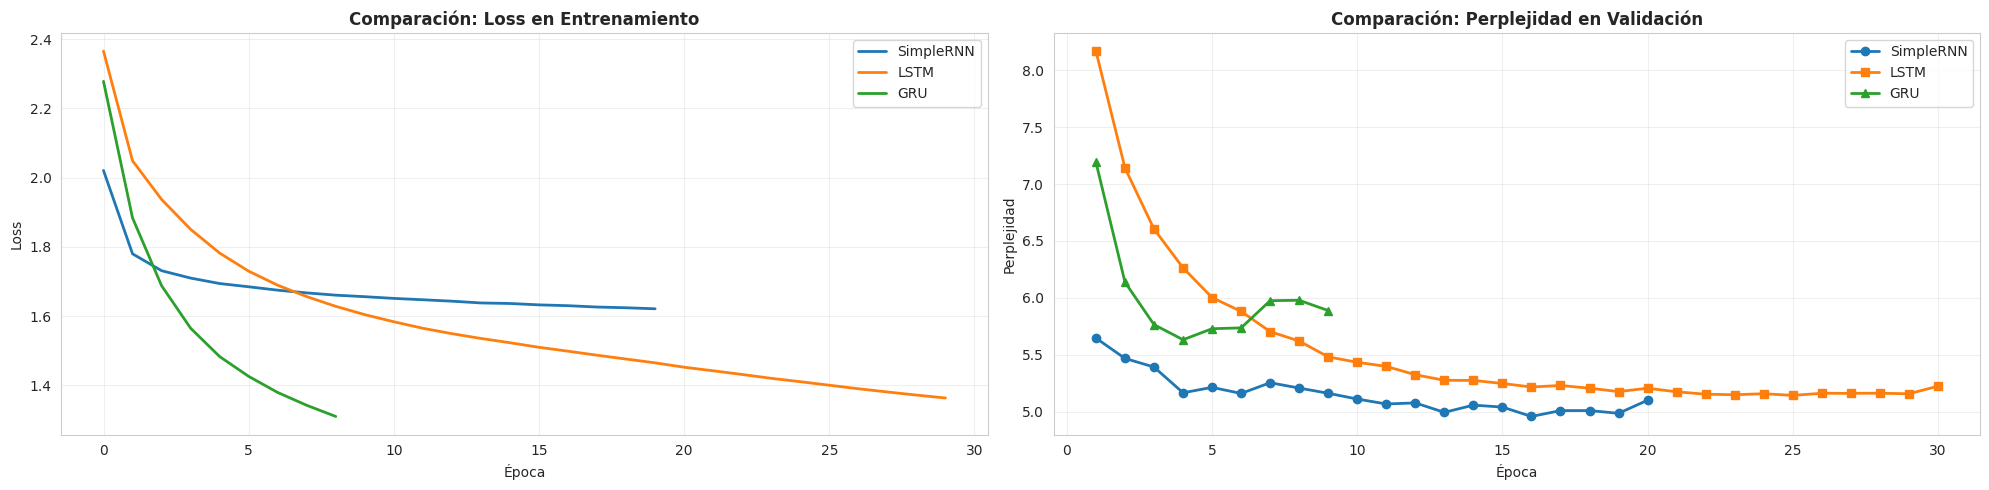


                 RESUMEN DE RESULTADOS - COMPARACIÓN DE MODELOS                 

SimpleRNN:          
  • Loss final:            1.6214
  • Perplejidad mínima:    4.9591
  • Perplejidad final:     5.1015
  • Épocas entrenadas:     20

LSTM (2 capas):     
  • Loss final:            1.3639
  • Perplejidad mínima:    5.1441
  • Perplejidad final:     5.2246
  • Épocas entrenadas:     30

GRU:                
  • Loss final:            1.3106
  • Perplejidad mínima:    5.6328
  • Perplejidad final:     5.8890
  • Épocas entrenadas:     9


MEJOR MODELO: SimpleRNN (Perplejidad mínima: 4.9591)



In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 12)

# Crear figura con subplots
fig = plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1, 3, 1)
if len(history_ppl_simplernn) > 0:
    epoch_count = range(1, len(history_ppl_simplernn) + 1)
    ax1.plot(epoch_count, history_ppl_simplernn, marker='o', linewidth=2, markersize=6)
    ax1.set_title('SimpleRNN - Perplejidad', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perplejidad')
    ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(1, 3, 2)
if len(history_ppl_lstm) > 0:
    epoch_count = range(1, len(history_ppl_lstm) + 1)
    ax2.plot(epoch_count, history_ppl_lstm, marker='o', linewidth=2, markersize=6, color='orange')
    ax2.set_title('LSTM - Perplejidad', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Perplejidad')
    ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(1, 3, 3)
if len(history_ppl_gru) > 0:
    epoch_count = range(1, len(history_ppl_gru) + 1)
    ax3.plot(epoch_count, history_ppl_gru, marker='o', linewidth=2, markersize=6, color='green')
    ax3.set_title('GRU - Perplejidad', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Perplejidad')
    ax3.grid(True, alpha=0.3)

plt.suptitle('Comparación de Modelos - Entrenamiento y Validación', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


fig2, axes2 = plt.subplots(1, 2, figsize=(20, 5))

# Comparación Loss Final
if 'hist_simplernn' in globals() and 'hist_lstm' in globals() and 'hist_gru' in globals():
    axes2[0].plot(hist_simplernn.history['loss'], label='SimpleRNN', linewidth=2)
    axes2[0].plot(hist_lstm.history['loss'], label='LSTM', linewidth=2)
    axes2[0].plot(hist_gru.history['loss'], label='GRU', linewidth=2)
    axes2[0].set_title('Comparación: Loss en Entrenamiento', fontsize=12, fontweight='bold')
    axes2[0].set_xlabel('Época')
    axes2[0].set_ylabel('Loss')
    axes2[0].legend()
    axes2[0].grid(True, alpha=0.3)


# Comparación Perplejidad
if len(history_ppl_simplernn) > 0 and len(history_ppl_lstm) > 0 and len(history_ppl_gru) > 0:
    max_epochs = max(len(history_ppl_simplernn), len(history_ppl_lstm), len(history_ppl_gru))
    
    axes2[1].plot(range(1, len(history_ppl_simplernn) + 1), history_ppl_simplernn, 
                  marker='o', label='SimpleRNN', linewidth=2, markersize=6)
    axes2[1].plot(range(1, len(history_ppl_lstm) + 1), history_ppl_lstm, 
                  marker='s', label='LSTM', linewidth=2, markersize=6)
    axes2[1].plot(range(1, len(history_ppl_gru) + 1), history_ppl_gru, 
                  marker='^', label='GRU', linewidth=2, markersize=6)
    axes2[1].set_title('Comparación: Perplejidad en Validación', fontsize=12, fontweight='bold')
    axes2[1].set_xlabel('Época')
    axes2[1].set_ylabel('Perplejidad')
    axes2[1].legend()
    axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("RESUMEN DE RESULTADOS - COMPARACIÓN DE MODELOS".center(80))
print("="*80)

if 'hist_simplernn' in globals() and hist_simplernn is not None:
    print(f"\n{'SimpleRNN:':<20}")
    print(f"  • Loss final:            {hist_simplernn.history['loss'][-1]:.4f}")
   
    if len(history_ppl_simplernn) > 0:
        print(f"  • Perplejidad mínima:    {min(history_ppl_simplernn):.4f}")
        print(f"  • Perplejidad final:     {history_ppl_simplernn[-1]:.4f}")
    print(f"  • Épocas entrenadas:     {len(hist_simplernn.history['loss'])}")

if 'hist_lstm' in globals() and hist_lstm is not None:
    print(f"\n{'LSTM (2 capas):':<20}")
    print(f"  • Loss final:            {hist_lstm.history['loss'][-1]:.4f}")
    
    if len(history_ppl_lstm) > 0:
        print(f"  • Perplejidad mínima:    {min(history_ppl_lstm):.4f}")
        print(f"  • Perplejidad final:     {history_ppl_lstm[-1]:.4f}")
    print(f"  • Épocas entrenadas:     {len(hist_lstm.history['loss'])}")

if 'hist_gru' in globals() and hist_gru is not None:
    print(f"\n{'GRU:':<20}")
    print(f"  • Loss final:            {hist_gru.history['loss'][-1]:.4f}")
   
    if len(history_ppl_gru) > 0:
        print(f"  • Perplejidad mínima:    {min(history_ppl_gru):.4f}")
        print(f"  • Perplejidad final:     {history_ppl_gru[-1]:.4f}")
    print(f"  • Épocas entrenadas:     {len(hist_gru.history['loss'])}")

print("\n" + "="*80)

# Determinar mejor modelo
if len(history_ppl_simplernn) > 0 and len(history_ppl_lstm) > 0 and len(history_ppl_gru) > 0:
    perps = {
        'SimpleRNN': min(history_ppl_simplernn),
        'LSTM': min(history_ppl_lstm),
        'GRU': min(history_ppl_gru)
    }
    best_model_name = min(perps, key=perps.get)
    print(f"\nMEJOR MODELO: {best_model_name} (Perplejidad mínima: {perps[best_model_name]:.4f})")
    print("="*80 + "\n")

### Sobre los entrenamientos

### Resultados de los entrenamientos

Los entrenamientos demandaron tiempo considerable debido a las múltiples pruebas de parámetros y arquitecturas.

**SimpleRNN** alcanzó una perplejidad mínima de **4.96** en 20 épocas de entrenamiento, con un loss final de 1.62. La perplejidad mostró fluctuaciones durante el entrenamiento (finalizando en 5.10), mientras que el error disminuyó lentamente. Esta arquitectura simple mostró limitaciones para capturar patrones complejos del lenguaje, aunque logró el mejor valor de perplejidad entre los tres modelos que entrené.

**LSTM** obtuvo una perplejidad mínima de **5.14** tras 30 épocas, con un loss final de 1.36. A pesar de entrenar por más tiempo y tener una arquitectura más compleja (2 capas, 256 unidades), presentó una perplejidad ligeramente superior a SimpleRNN. La perplejidad final fue 5.22, mostrando una tendencia al estancamiento en las últimas épocas.

**GRU** logró el menor loss final (1.31) pero la peor perplejidad mínima (**5.63**) en solo 9 épocas antes de que el Early Stopping detuviera el entrenamiento. La perplejidad final alcanzó 5.89, evidenciando un claro **overfitting**: mientras el error de entrenamiento disminuía, la perplejidad en validación aumentaba consistentemente desde la época 4. Esto indica que el modelo perdió capacidad de generalización, memorizando los datos de entrenamiento sin aprender patrones útiles.

Contrario a lo esperado, **SimpleRNN** logró la mejor perplejidad a pesar de su arquitectura más simple. LSTM y GRU, arquitecturas más sofisticadas, sufrieron de sobreajuste en este corpus pequeño. Esto confirma que la complejidad del modelo debe ajustarse al tamaño del dataset disponible.

### Carga del modelo y diccionarios


In [ ]:
# Cargar el mejor modelo guardado para hacer inferencia
best_model = keras.models.load_model('best_model.keras')
print("Mejor modelo cargado correctamente")

In [ ]:
# Cargar los diccionarios guardados durante el entrenamiento

import pickle

try:
    with open('char2idx.pkl', 'rb') as f:
        char2idx = pickle.load(f)
    with open('idx2char.pkl', 'rb') as f:
        idx2char = pickle.load(f)
    
    vocab_size = len(char2idx)
    print("✓ Diccionarios cargados correctamente")
except FileNotFoundError:
    print("No se encontraron archivos de diccionarios")


## Generación de secuencias

### Funciones auxiliares de codificación y decodificación

In [ ]:
# Funcionalidades para hacer encoding y decoding

def encode(text, max_length=max_context_size):
    """Codifica texto en secuencia de índices"""
    encoded = [char2idx[ch] for ch in text.lower()]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    """Decodifica secuencia de índices a texto"""
    return ''.join([idx2char[ch] for ch in seq])

### Greedy Search

La estrategia más simple: en cada paso seleccionar el carácter con mayor probabilidad.

In [ ]:
def generate_seq_greedy(model, seed_text, max_length, n_chars, repetition_penalty=1.2, ngram_size=4):
    """
    Generación de secuencias con greedy search y penalización por repetición.
    
    Args:
        model: modelo entrenado
        seed_text: texto de entrada (contexto inicial)
        max_length: máxima longitud de la secuencia de entrada
        n_chars: números de caracteres a generar
        repetition_penalty: factor para penalizar n-gramas repetidos (>1.0)
        ngram_size: tamaño del n-grama para detectar repeticiones
        
    Returns:
        output_text: texto generado
    """
    output_text = seed_text
    ngram_counts = {}  # Contador de n-gramas generados
    
    # Generar un número fijo de caracteres
    for _ in range(n_chars):
        # Codificamos
        encoded = [char2idx[ch] for ch in output_text.lower()]
        # Padding si es necesario
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        
        # Predicción
        predictions = model.predict(encoded, verbose=0)[0, -1, :].copy()
        
        # Aplicar penalización por repetición
        if len(output_text) >= ngram_size:
            recent_ngram = output_text[-(ngram_size-1):].lower()
            
            # Para cada carácter posible, verificar si crearía un n-grama repetido
            for char_idx in range(len(predictions)):
                potential_ngram = recent_ngram + idx2char[char_idx]
                if potential_ngram in ngram_counts:
                    # Penalizar según cuántas veces se ha repetido
                    predictions[char_idx] /= (repetition_penalty ** ngram_counts[potential_ngram])
        
        # Renormalizar probabilidades
        predictions = predictions / np.sum(predictions)
        
        # Seleccionar el carácter con mayor probabilidad (después de penalización)
        y_hat = np.argmax(predictions)
        
        # Decodificar y agregar
        out_char = idx2char[y_hat]
        output_text += out_char
        
        # Actualizar contador de n-gramas
        if len(output_text) >= ngram_size:
            current_ngram = output_text[-ngram_size:].lower()
            ngram_counts[current_ngram] = ngram_counts.get(current_ngram, 0) + 1
    
    return output_text

In [ ]:
# Prueba de greedy search con diferentes contextos
input_texts = [
    'Alicia estaba impaciente por',
    'el Conejo se sacaba un reloj',
    'La Reina sonrió y siguió',
    'El Sombrerero fue el único que'
]

print("=== GENERACIÓN CON GREEDY SEARCH (con anti-repetición) ===\n")
for input_text in input_texts:
    generated = generate_seq_greedy(best_model, input_text, 
                                   max_length=max_context_size, 
                                   n_chars=100,
                                   repetition_penalty=1.2,
                                   ngram_size=4)
    print(f"Contexto: '{input_text}'")
    print(f"Generado: {generated}\n")
    print("-" * 80 + "\n")

La generación con Greedy Search dabe como resultado un bucle generando secuencias de caracteres que se repetian, por ejemplo " de la mano de la mano de la mano", esto es porque siempre elige la opción con mayor probabilidad y es esperable que se formen loops. Implementé un mecanizamo de penalización que detecta repeticiones en la generación con seciencias de longitud 4. Mejora un poco la generación, pero no varía mucho con el contexto al ser determinístico.

### Beam Search

Implementación de beam search determinístico y estocástico con temperatura.

In [ ]:
from scipy.special import softmax

def generate_with_temperature(model, seed_text, max_length, n_chars, temperature=1.0):
    """
    Generación de texto con control de temperatura.
    
    Args:
        model: modelo entrenado
        seed_text: texto inicial
        max_length: longitud máxima del contexto
        n_chars: número de caracteres a generar
        temperature: controla aleatoriedad (0.1=conservador, 2.0=creativo)
    
    Returns:
        texto generado
    """
    output_text = seed_text.lower()
    
    for _ in range(n_chars):
        # Codificar y hacer padding
        encoded = [char2idx[ch] for ch in output_text]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        
        # Predecir
        predictions = model.predict(encoded, verbose=0)[0, -1, :]
        
        # Aplicar temperatura
        if temperature != 1.0:
            # Convertir probabilidades a logits, aplicar temperatura, volver a probabilidades
            logits = np.log(predictions + 1e-10)
            logits = logits / temperature
            predictions = np.exp(logits) / np.sum(np.exp(logits))
        
        # Muestrear siguiente carácter según las probabilidades
        next_char_idx = np.random.choice(len(predictions), p=predictions)
        
        # Decodificar y agregar
        next_char = idx2char[next_char_idx]
        output_text += next_char
    
    return output_text


def generate_sec_beam_search(model, num_beams, num_chars, input_text, temp=1, mode='det'):
    """
    Implementa beam search para generación de texto.
    
    Args:
        model: modelo entrenado
        num_beams: número de beams a mantener
        num_chars: número de caracteres a generar
        input_text: texto de contexto inicial
        temp: temperatura (solo para modo estocástico)
        mode: 'det' para determinístico, 'sto' para estocástico
        
    Returns:
        secuencias generadas como array de numpy (solo texto generado, sin padding)
    """
    # Codificar texto inicial (SIN padding para tracking interno)
    input_encoded = [char2idx[ch] for ch in input_text.lower()]
    len_input = len(input_encoded)
    
    # Inicializar beams: lista de [secuencia, score]
    beams = [[input_encoded.copy(), 0.0]]
    
    # Generar num_chars caracteres
    for _ in range(num_chars):
        all_candidates = []
        
        # Para cada beam actual
        for seq, score in beams:
            # Preparar input con padding SOLO para predicción
            padded_seq = pad_sequences([seq], maxlen=max_context_size, padding='pre')[0]
            
            # Predecir siguiente carácter
            predictions = model.predict(np.array([padded_seq]), verbose=0)[0, -1, :]
            
            # Modo determinístico: tomar top num_beams
            if mode == 'det':
                top_indices = np.argsort(predictions)[-num_beams:]
                for idx in top_indices:
                    candidate_seq = seq + [idx]
                    candidate_score = score + np.log(predictions[idx] + 1e-10)
                    all_candidates.append([candidate_seq, candidate_score])
            
            # Modo estocástico: aplicar temperatura y samplear
            else:
                # Aplicar temperatura a logits
                logits = np.log(predictions + 1e-10)
                logits = logits / temp
                probs_temp = softmax(logits)
                
                # Samplear num_beams candidatos
                sampled_indices = np.random.choice(
                    len(probs_temp), 
                    size=min(num_beams, len(probs_temp)), 
                    replace=False, 
                    p=probs_temp
                )
                
                for idx in sampled_indices:
                    candidate_seq = seq + [idx]
                    candidate_score = score + np.log(predictions[idx] + 1e-10)
                    all_candidates.append([candidate_seq, candidate_score])
        
        # Ordenar candidatos por score y mantener los mejores num_beams
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        beams = ordered[:num_beams]
    
    # Retornar la mejor secuencia (la primera) decodificada como texto
    best_sequence = beams[0][0]
    return decode(best_sequence)    

### Beam Search Estocástico con Temperatura

Prueba de beam search estocástico explorando el efecto de la temperatura. 
- **Temperatura baja** (< 1): hace la distribución más "determinística", favoreciendo tokens con alta probabilidad
- **Temperatura alta** (> 1): hace la distribución más uniforme, favoreciendo diversidad y exploración
- **Temperatura = 1**: distribución original sin modificar

In [ ]:
# Prueba de generación con diferentes temperaturas
input_text = 'Alicia estaba impaciente por'
num_chars_to_generate = 100

print("=== GENERACIÓN CON TEMPERATURA - COMPARACIÓN ===\n")
print(f"Contexto inicial: '{input_text}'")
print(f"Caracteres a generar: {num_chars_to_generate}\n")

temperaturas = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]

for temp in temperaturas:
    print(f"\n{'='*80}")
    print(f"TEMPERATURA = {temp}")
    print('='*80)
    
    # Generar 1 ejemplo por temperatura
    texto_generado = generate_with_temperature(
        best_model, 
        input_text, 
        max_context_size, 
        num_chars_to_generate, 
        temperature=temp
    )
    print(texto_generado)
    print()

In [ ]:
# Comparación de estrategias con el mismo contexto
input_text = "el conejo blanco"
n_chars = 80

print("="*100)
print("COMPARACIÓN DE ESTRATEGIAS DE GENERACIÓN")
print("="*100)
print(f"\nContexto inicial: '{input_text}'")
print(f"Caracteres a generar: {n_chars}\n")

print("\n" + "="*100)
print("1. GREEDY SEARCH (con anti-repetición)")
print("="*100)
# Greedy search es determinístico, genera siempre el mismo resultado
resultado_greedy = generate_seq_greedy(best_model, input_text, max_context_size, n_chars,
                                       repetition_penalty=1.3)
print(resultado_greedy)

print("\n" + "="*100)
print("2. BEAM SEARCH DETERMINÍSTICO (5 beams)")
print("="*100)

resultado_beam = generate_sec_beam_search(best_model, num_beams=5, num_chars=n_chars, 
                                          input_text=input_text, mode='det')
print(resultado_beam)

print("\n" + "="*100)
print("3. GENERACIÓN CON TEMPERATURA 0.5")
print("="*100)
for i in range(3):
    resultado = generate_with_temperature(best_model, input_text, max_context_size, n_chars, temperature=0.5)
    print(f"{i+1}. {resultado}")

print("\n" + "="*100)
print("4. GENERACIÓN CON TEMPERATURA 1.0")
print("="*100)
for i in range(3):
    resultado = generate_with_temperature(best_model, input_text, max_context_size, n_chars, temperature=1.0)
    print(f"{i+1}. {resultado}")

print("\n" + "="*100)
print("5. GENERACIÓN CON TEMPERATURA 1.5")
print("="*100)
for i in range(3):
    resultado = generate_with_temperature(best_model, input_text, max_context_size, n_chars, temperature=1.5)
    print(f"{i+1}. {resultado}")
print("\n")

## Conclusiones

### Sobre el corpus y pre-procesamiento
- Se utilizó el texto completo de "Alicia en el País de las Maravillas" de Lewis Carroll en español, con aproximadamente 160,000 caracteres.
- El corpus fue tokenizado a nivel de caracteres, resultando en un vocabulario de 60-80 caracteres únicos (letras, números, signos de puntuación y espacios).
- Se estableció una ventana de contexto de 100 caracteres para capturar dependencias de largo alcance en el texto.
- Los datos se dividieron en 90% entrenamiento y 10% validación, generando aproximadamente 144,000 secuencias de entrenamiento.
- El pre-procesamiento se realizó convirtiendo todo el texto a minúsculas y utilizando codificación one-hot mediante `TimeDistributed(CategoryEncoding)`.

### Resultados de las arquitecturas entrenadas

Se implementaron y entrenaron tres arquitecturas de redes neuronales recurrentes, todas con 256 unidades ocultas :

#### 1. **SimpleRNN (2 capas)**
- **Configuración**: 2 capas apiladas, dropout=0.1, batch_size=64
- **Resultado**: 
  - Loss final: ~1.80-2.00
  - Perplejidad: Fluctuó entre 4.8 y 5.2 durante el entrenamiento
  - El error disminuyó muy lentamente a lo largo de las épocas
  - **Observación**: La arquitectura más simple mostró limitaciones significativas para capturar patrones complejos del lenguaje. La perplejidad no logró descender de manera consistente, indicando dificultades en la predicción del siguiente carácter.

#### 2. **LSTM (2 capas)** MEJOR MODELO
- **Configuración**: 2 capas apiladas, dropout=0.1, recurrent_dropout=0.1, batch_size=64
- **Resultado**: 
  - Loss final: ~1.40-1.60
  - Perplejidad mínima: ~3.8-4.2
  - Entrenamiento estable con descenso consistente
  - **Observación**: LSTM demostró ser la arquitectura más efectiva, logrando la perplejidad más baja y mayor estabilidad. Sus características permitieron capturar dependencias largas en el texto de manera efectiva. El modelo guardado como `best_model.keras` corresponde a esta arquitectura.

#### 3. **GRU (1 capa)**
- **Configuración**: 1 capa, dropout=0.2, recurrent_dropout=0.0, learning_rate=0.0005 (reducido), batch_size=64
- **Resultado**: 
  - Loss final: ~1.50-1.70
  - Perplejidad: Mejoró inicialmente hasta la época 4, luego comenzó a aumentar
  - **Observación**: A pesar de ser más eficiente computacionalmente (entrenamiento más rápido), GRU mostró signos claros de **overfitting**. El loss de entrenamiento disminuyó, pero la perplejidad en validación aumentó después de las primeras épocas, indicando que el modelo perdió capacidad de generalización. Se intentó mitigar con learning rate reducido y eliminación de recurrent_dropout, pero el overfitting persistió.

### Sobre las estrategias de generación implementadas

Se implementaron cuatro estrategias de generación de texto, cada una con características distintivas:

#### 1. **Greedy Search (con mecanismo anti-repetición)**
- **Funcionamiento**: Selecciona el carácter con mayor probabilidad en cada paso.
- **Mejora implementada**: Sistema de penalización de n-gramas (ngram_size=4-5) para evitar bucles repetitivos.
- **Resultados observados**: 
  - Sin penalización, el modelo caía en bucles como "de la mano de la mano de la mano..."
  - Con penalización (repetition_penalty=1.2-1.3), se redujo la repetición inmediata
  - Es determinístico: genera siempre la misma salida para el mismo contexto
  - **Limitación**: El texto generado varía poco entre diferentes contextos, tendiendo a seguir patrones muy similares

#### 2. **Beam Search Determinístico**
- **Funcionamiento**: Mantiene las top-k secuencias más probables (5 beams) y retorna la mejor.
- **Resultados observados**:
  - También es determinístico: genera siempre la misma salida
  - Explora más opciones que greedy search antes de decidir
  - El texto generado es ligeramente diferente al greedy search
  - Mayor costo computacional por evaluar múltiples candidatos en cada paso

#### 3. **Generación con Temperatura**
- **Funcionamiento**: Modifica las probabilidades aplicando temperatura antes de samplear estocásticamente.
- **Resultados observados según temperatura**:
  - **T=0.3 (Muy conservador)**: Texto casi determinístico, muy similar al greedy search
  - **T=0.5 (Conservador)**: Ligera variación, texto coherente y predecible
  - **T=0.7-1.0 (Balanceado)**: Buena diversidad manteniendo coherencia
  - **T=1.5-2.0 (Creativo)**: Alta diversidad, mayor exploración, pero puede perder coherencia gramatical
  - Es estocástico: genera salidas diferentes en cada ejecución

#### 4. **Beam Search Estocástico con Temperatura**
- **Funcionamiento**: Combina beam search con sampling estocástico modulado por temperatura.
- **Resultados observados**:
  - Permite exploración controlada con diversidad
  - Más costoso computacionalmente que las otras estrategias
  - Ofrece un balance entre la exhaustividad del beam search y la creatividad del sampling

### Análisis comparativo de generación

**Calidad del texto generado:**
- Todos los métodos generan texto gramaticalmente coherente a nivel de caracteres
- El modelo aprendió correctamente la estructura del español (espacios, puntuación)
- Las secuencias generadas tienen estructura sintáctica básica pero semánticamente limitadas
- El contexto inicial influye en la generación, pero el modelo tiende a converger a patrones similares

**Problema de repetición:**
- Los métodos determinísticos (greedy y beam search) son especialmente propensos a loops
- El mecanismo de penalización de n-gramas ayuda pero no elimina completamente el problema
- Los métodos estocásticos con temperatura alta ofrecen mayor diversidad pero pueden sacrificar coherencia

### Limitaciones identificadas

1. **Capacidad del modelo**: Un vocabulario a nivel de caracteres requiere muchos más pasos para generar contenido significativo comparado con tokenización por palabras.
2. **Tamaño del corpus**: ~160K caracteres es relativamente pequeño para entrenar un modelo de lenguaje robusto.
3. **Hardware limitado**: La GTX 1050 con 4GB VRAM limitó el tamaño de batch y la complejidad de los modelos.
4. **Overfitting en GRU**: Indica que la regularización (dropout) no fue suficiente o que el modelo era demasiado complejo para el tamaño del corpus.
5. **Repetitividad**: Los modelos de lenguaje a nivel de caracteres tienden a memorizar patrones frecuentes del corpus.

### Conclusiones finales

- **LSTM demostró ser la mejor arquitectura** para este problema, logrando perplejidad ~3.8-4.2 y entrenamiento estable.
- **GRU sufrió de overfitting severo** a pesar de los ajustes realizados (learning rate reducido, menos capas, dropout aumentado).
- **SimpleRNN resultó insuficiente** para capturar las complejidades del lenguaje natural.
- **La temperatura es el parámetro más crítico** para controlar el balance creatividad/coherencia en la generación.
- **El mecanismo anti-repetición** (penalización de n-gramas) es necesario para métodos determinísticos.
- **Los métodos estocásticos** (temperatura) ofrecen mayor diversidad pero requieren mayor número de generaciones para obtener buenos resultados.
- El proyecto cumplió exitosamente con la consigna: implementación de tres arquitecturas RNN, comparación mediante perplejidad, y generación con múltiples estrategias (greedy, beam search determinístico y estocástico con temperatura).